In [1]:
import os
import cv2
import numpy as np

In [2]:
def load_images_and_labels(test_dir, class_labels):
    X_vec = []
    y_vec = []

    for class_name, label in class_labels.items():
        class_dir = os.path.join(test_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)  # Convert to RGB
            img_resized = cv2.resize(img_rgb, (96, 96))  # Resize image to 48x48
            X_vec.append(img_resized)
            y_vec.append(label)

    # Convert lists to NumPy arrays
    X_vec = np.array(X_vec)
    y_vec = np.array(y_vec)

    return X_vec, y_vec


class_labels_reversed = {
    0: 'anger',
    1: 'contempt',
    2: 'disgust',
    3: 'fear',
    4: 'happiness',
    5: 'neutral',
    6: 'sadness',
    7: 'surprise'
}


test_dir = r"C:\Users\hunto\projects\onlab\fer_plus\FERPlus\data\FER2013Test_labeled"
train_dir = r"C:\Users\hunto\projects\onlab\fer_plus\FERPlus\data\FER2013Train_labeled"
class_labels = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'neutral': 5,
    'sadness': 6,
    'surprise': 7
}

X_test, y_test = load_images_and_labels(test_dir, class_labels)
X_train, y_train = load_images_and_labels(train_dir, class_labels)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import numpy as np
from skimage.color import rgb2gray
from sklearn.base import BaseEstimator, TransformerMixin

class PipeStep(BaseEstimator, TransformerMixin):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func = step_func

    def fit(self, *args):
        return self

    def transform(self, X):
        return self._step_func(X)

class KerasModelStep(BaseEstimator, TransformerMixin):
    """
    Custom pipeline step for integrating a Keras model
    """
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming X is the input data for the Keras model
        return self.keras_model.predict(X)

    def predict(self, X):
        raw_predictions = self.keras_model.predict(X)
        predicted_labels = np.argmax(raw_predictions, axis=1)
        return predicted_labels

    def predict_proba(self, X):
        return self.keras_model.predict(X)




# Assuming your Keras model expects input shape (image_height, image_width, channels)
# Modify the model architecture as needed if the input shape is different
class FlattenStep(BaseEstimator, TransformerMixin):
    """
    Custom pipeline step to flatten image data
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(X.shape[0], -1)


class CustomNormalizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to divide each pixel value by 255
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X / 255.0

In [4]:
from tensorflow.keras.models import model_from_json

# Load the model structure from the JSON file
json_file_path = r'C:\Users\hunto\projects\onlab\modellek-new\test11\4 val70-test69\emotion_model2.json'
with open(json_file_path, 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the weights into the model
h5_file_path = r'C:\Users\hunto\projects\onlab\modellek-new\test11\4 val70-test69\emotion_model2.h5'
loaded_emotion_model = model_from_json(loaded_model_json)
loaded_emotion_model.load_weights(h5_file_path)

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    # ('Make Gray', makegray_step),
    # ('Flatten Image', flatten_step),
    ('CustomNormalizer', CustomNormalizer()),
    # ('PCA', PCA(25)),
    # ('XGBoost', GradientBoostingClassifier())
    ('Keras Model', KerasModelStep(loaded_emotion_model))
                              ])



from sklearn.model_selection import train_test_split


# compute on remaining test data
pipe_pred_test = simple_rf_pipeline.predict(X_test)

pipe_pred_prop = simple_rf_pipeline.predict_proba(X_test)

In [5]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

# !pip install lime


%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime


from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime import lime_image

explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter =  SegmentationAlgorithm('felzenszwalb', n_segments=200, compactness=1, sigma=1)

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       322
           1       0.10      0.57      0.17        30
           2       0.16      0.76      0.26        21
           3       0.36      0.72      0.48        98
           4       0.91      0.86      0.89       929
           5       0.89      0.55      0.68      1274
           6       0.48      0.69      0.57       449
           7       0.76      0.75      0.75       450

    accuracy                           0.70      3573
   macro avg       0.54      0.70      0.56      3573
weighted avg       0.78      0.70      0.72      3573



C:\Users\hunto\.conda\envs\env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
pipe_pred_test[380:400]

array([3, 6, 3, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 3, 3, 7, 3, 3, 3, 3],
      dtype=int64)

In [16]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb



def visualize_explanation(explanation, num_features, label_index, class_labels_reversed, ax):
  label = list(explanation.local_exp.keys())[(-1) * label_index]
  temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=num_features,  hide_rest=False)
  ax.imshow(label2rgb(3-mask, temp, bg_label=0), interpolation='nearest')
  ax.axis('off')
  ax.set_title('{}'.format(class_labels_reversed[label]))








CPU times: total: 469 ms
Wall time: 802 ms


In [17]:
def explain(IMAGE_NUMBERS):
    for IMAGE_NUMBER in IMAGE_NUMBERS:
        
      explainer = lime_image.LimeImageExplainer(verbose = False)
      felzenszwalb =  SegmentationAlgorithm('felzenszwalb', n_segments=200, compactness=1, sigma=1)
      felzenszwalb_explanation = explainer.explain_instance(X_test[IMAGE_NUMBER],
                                              classifier_fn = simple_rf_pipeline.predict_proba,
                                              top_labels=8, hide_color=0, num_samples=10000, segmentation_fn=felzenszwalb)
        
      explainer = lime_image.LimeImageExplainer(verbose = False)
      quickshift  =  SegmentationAlgorithm('quickshift', n_segments=30, compactness=1, sigma=1)
      quickshift_explanation = explainer.explain_instance(X_test[IMAGE_NUMBER],
                                              classifier_fn = simple_rf_pipeline.predict_proba,
                                              top_labels=8, hide_color=0, num_samples=1000, segmentation_fn=quickshift)
        
      explainer = lime_image.LimeImageExplainer(verbose = False)
      slic  =  SegmentationAlgorithm('slic', n_segments=200, compactness=1, sigma=1)
      slic_explanation = explainer.explain_instance(X_test[IMAGE_NUMBER],
                                              classifier_fn = simple_rf_pipeline.predict_proba,
                                              top_labels=8, hide_color=0, num_samples=10000, segmentation_fn=slic)
    
      y = 3
      x = 6
    
      fig, axes = plt.subplots(y, x, figsize=(12, 8))
    
      titles = ['felzenszwalb', 'slic', 'quickshift']
    
      for i in range(y):
          axes[i, 0].imshow(X_test[IMAGE_NUMBER])
          axes[i, 0].set_title(titles[i], )
          axes[i, 0].axis('off')
    
      visualize_explanation(felzenszwalb_explanation, num_features=1, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[0, 1])
      visualize_explanation(felzenszwalb_explanation, num_features=3, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[0, 2])
      visualize_explanation(felzenszwalb_explanation, num_features=5, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[0, 3])
      visualize_explanation(felzenszwalb_explanation, num_features=15, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[0, 4])
      visualize_explanation(felzenszwalb_explanation, num_features=10000, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[0, 5])
      
      visualize_explanation(slic_explanation, num_features=1, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[1, 1])
      visualize_explanation(slic_explanation, num_features=3, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[1, 2])
      visualize_explanation(slic_explanation, num_features=5, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[1, 3])
      visualize_explanation(slic_explanation, num_features=15, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[1, 4])
      visualize_explanation(slic_explanation, num_features=10000, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[1, 5])
    
      visualize_explanation(quickshift_explanation, num_features=1, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[2, 1])
      visualize_explanation(quickshift_explanation, num_features=3, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[2, 2])
      visualize_explanation(quickshift_explanation, num_features=5, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[2, 3])
      visualize_explanation(quickshift_explanation, num_features=15, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[2, 4])
      visualize_explanation(quickshift_explanation, num_features=10000, label_index=1, class_labels_reversed=class_labels_reversed, ax=axes[2, 5])
    
      # Repeat for the other plots you want to add
    
      plt.tight_layout()
      plt.show()

In [18]:
# IMAGE_NUMBER = 149
IMAGE_NUMBERS0 =   [50,51,52,53,53,54,55] # anger
IMAGE_NUMBERS1 =   [352,353,355,356,357,358,359] # disgust
IMAGE_NUMBERS2 = [380,382,383,384,385,386,387] # fear

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.55it/s]


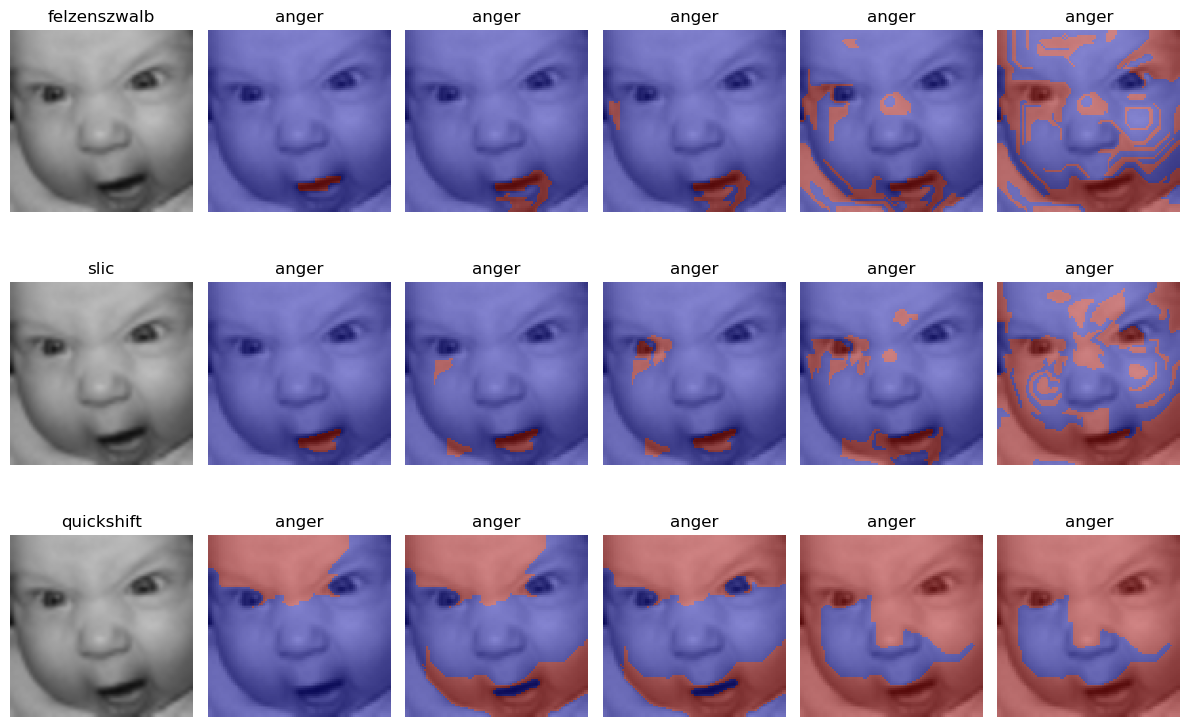

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 142.22it/s]


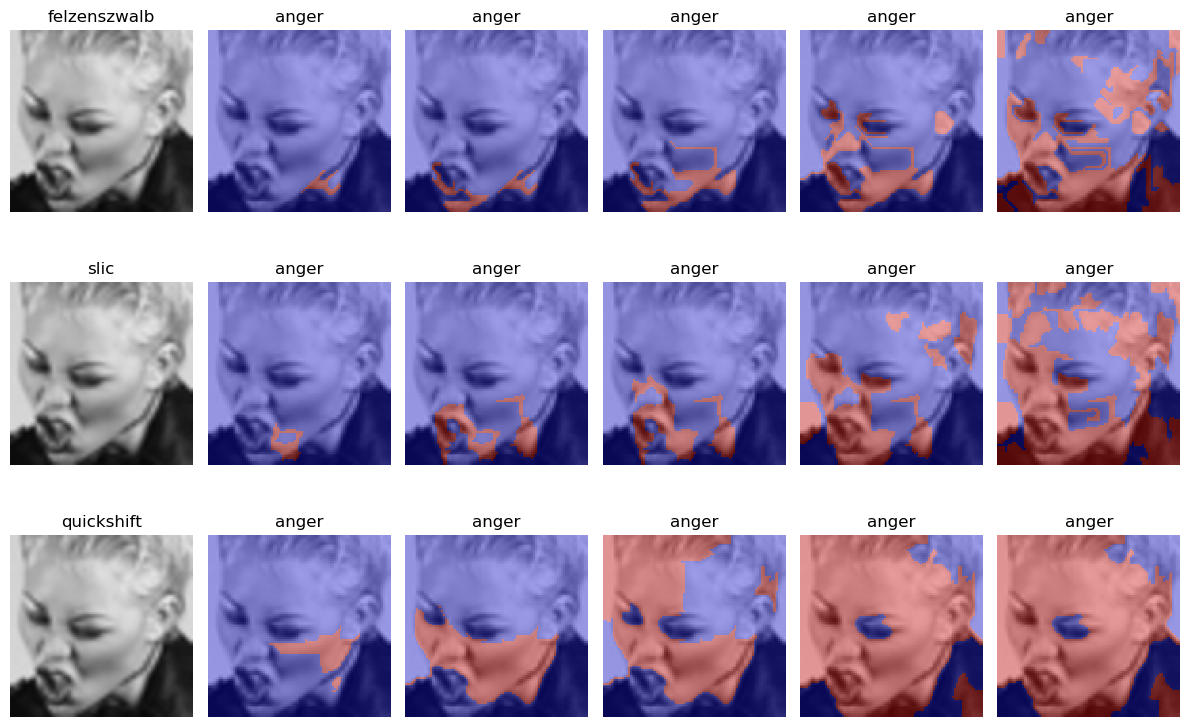

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 140.44it/s]


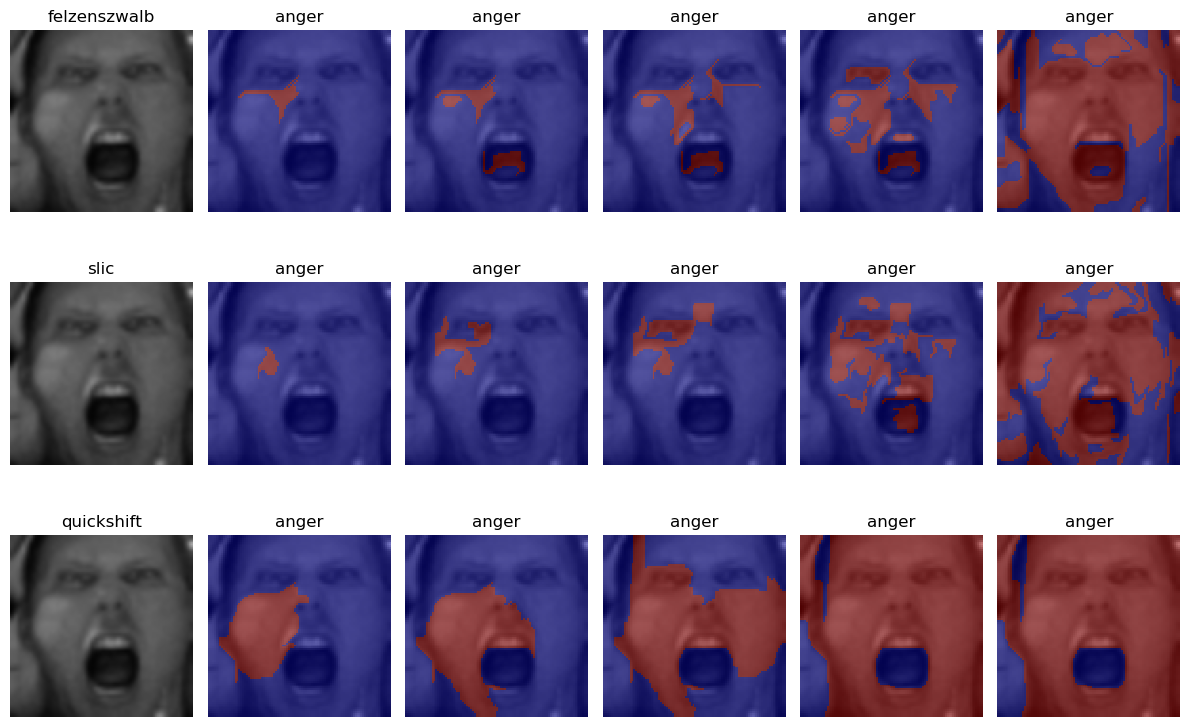

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.37it/s]


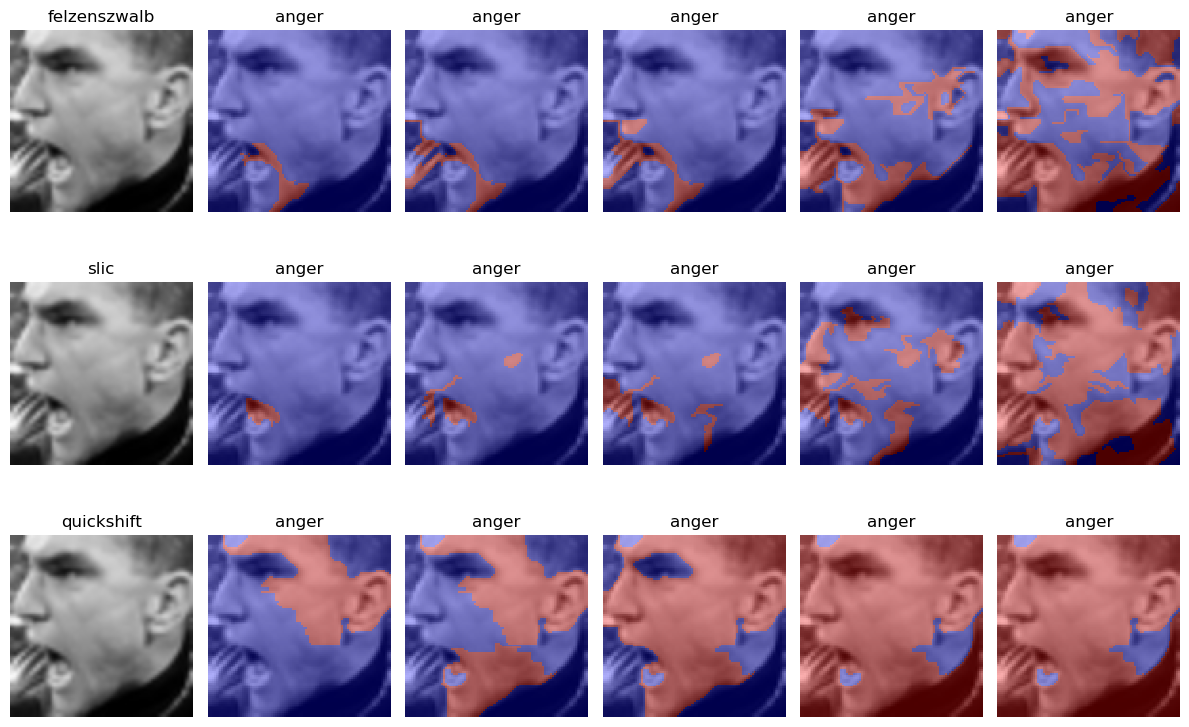

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 145.14it/s]


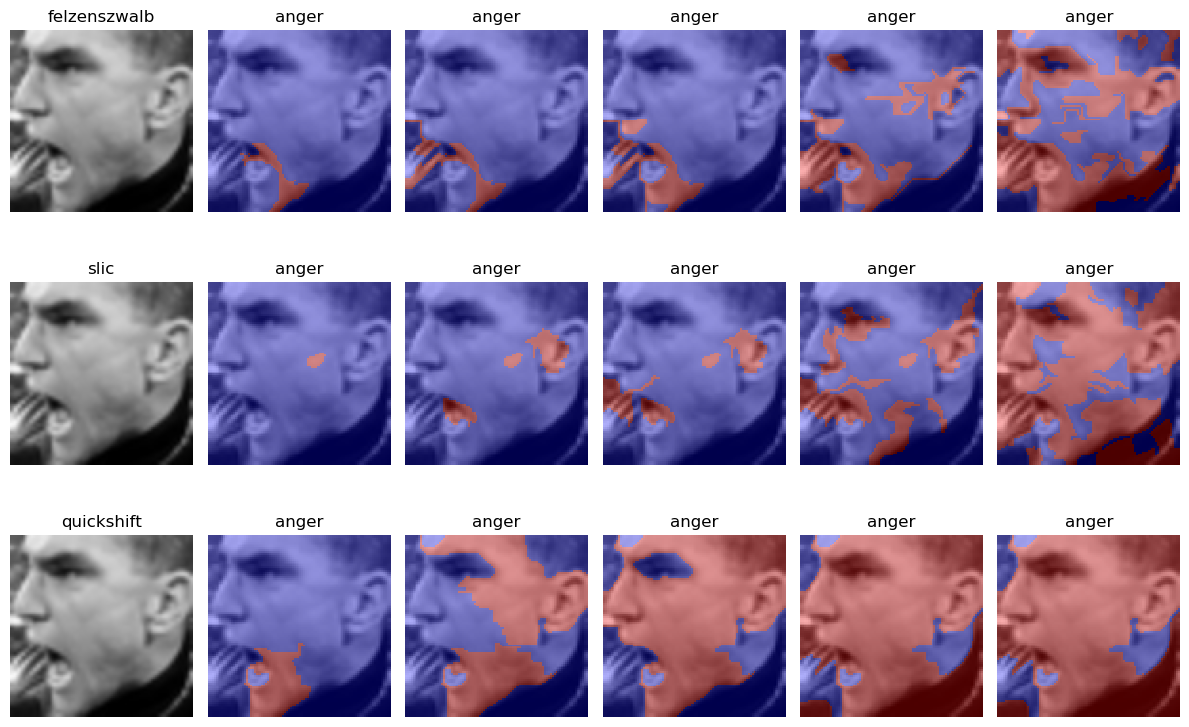

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.13it/s]


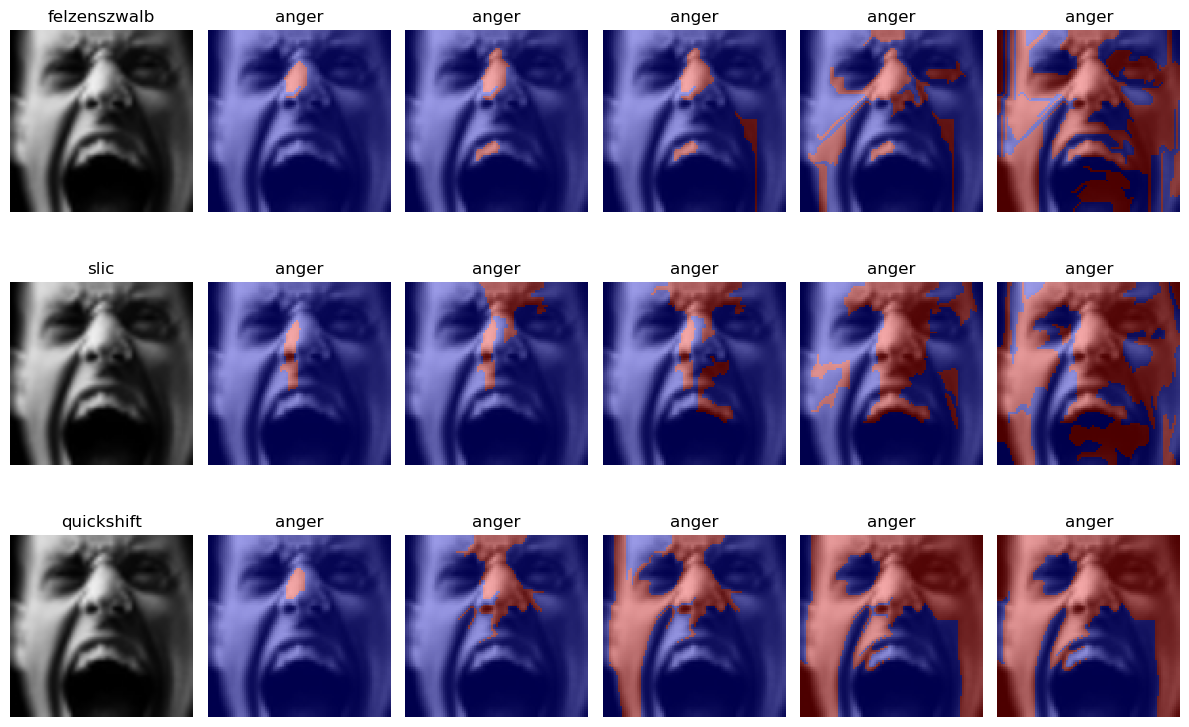

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 142.72it/s]


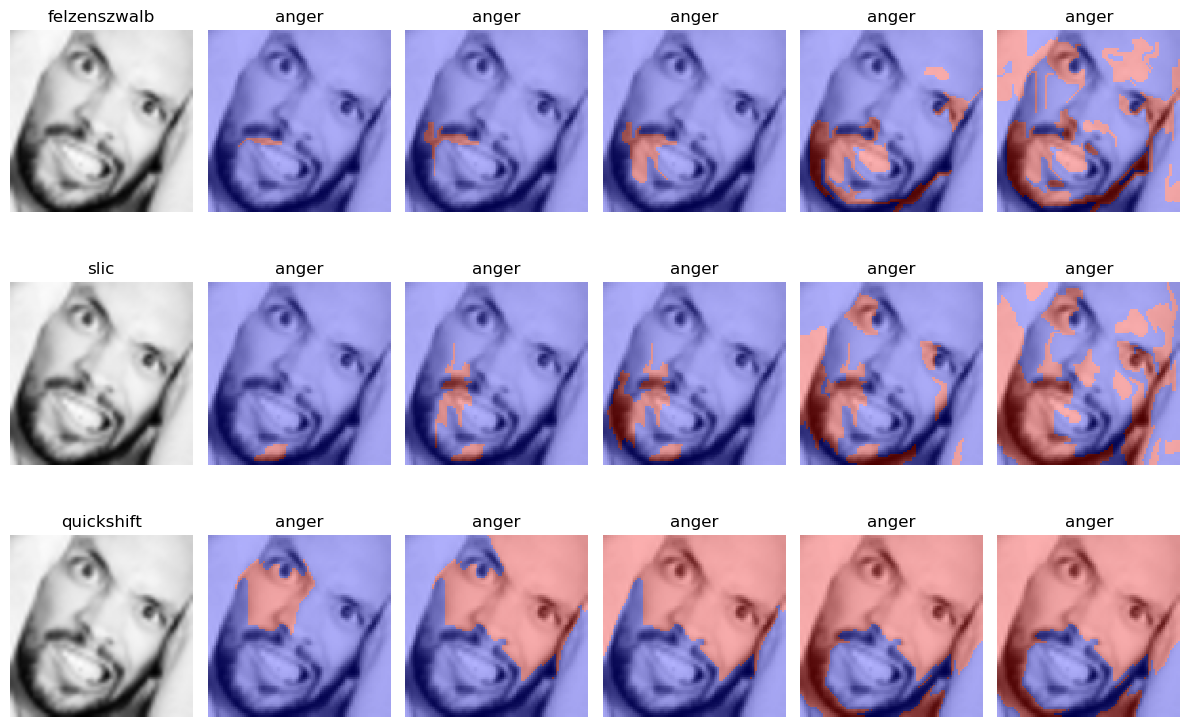

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.45it/s]


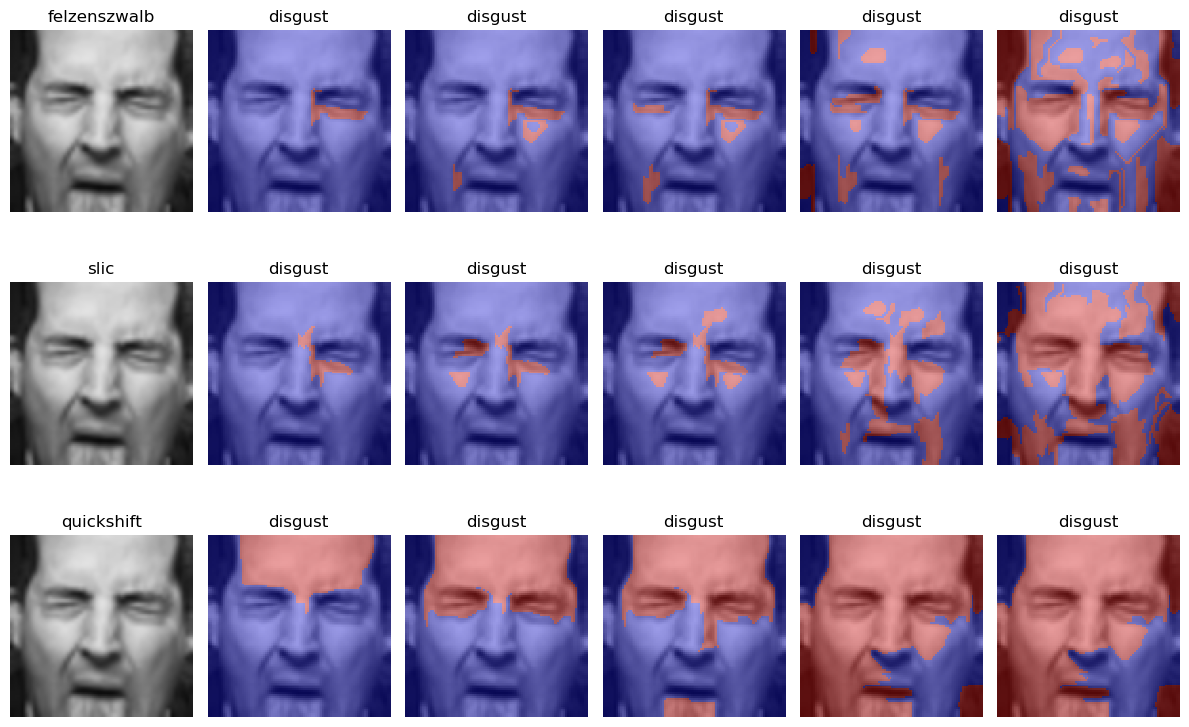

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.38it/s]


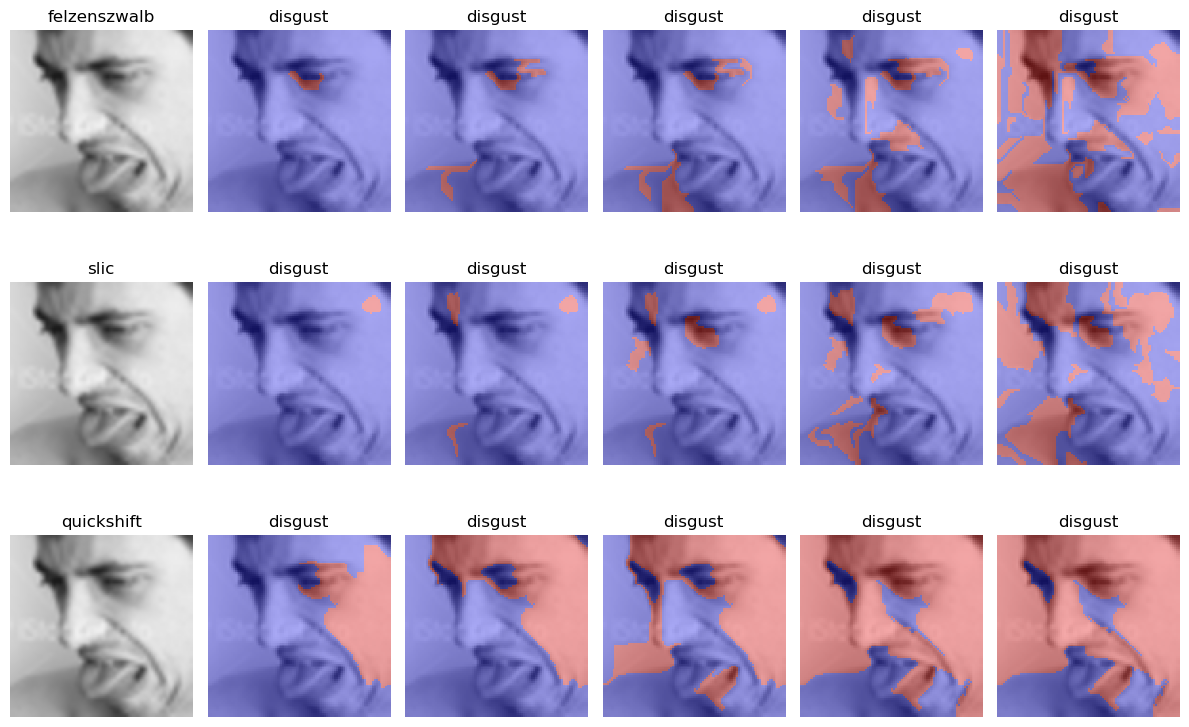

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:29<00:00, 111.54it/s]


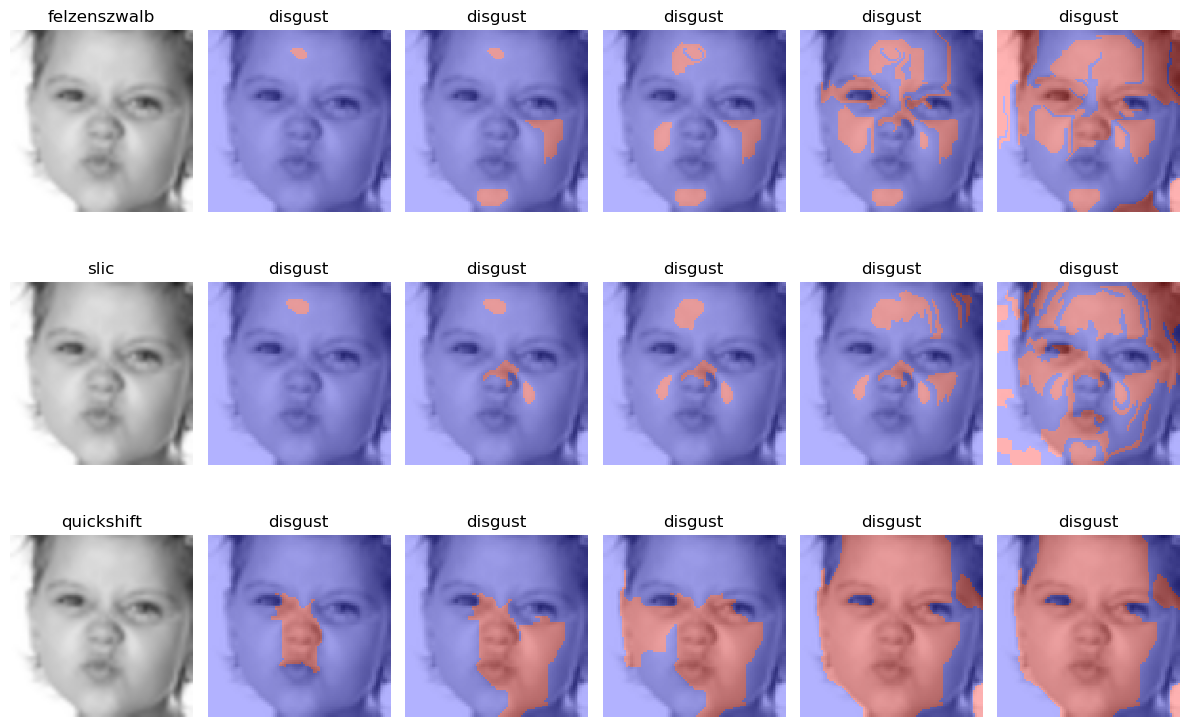

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:29<00:00, 112.12it/s]


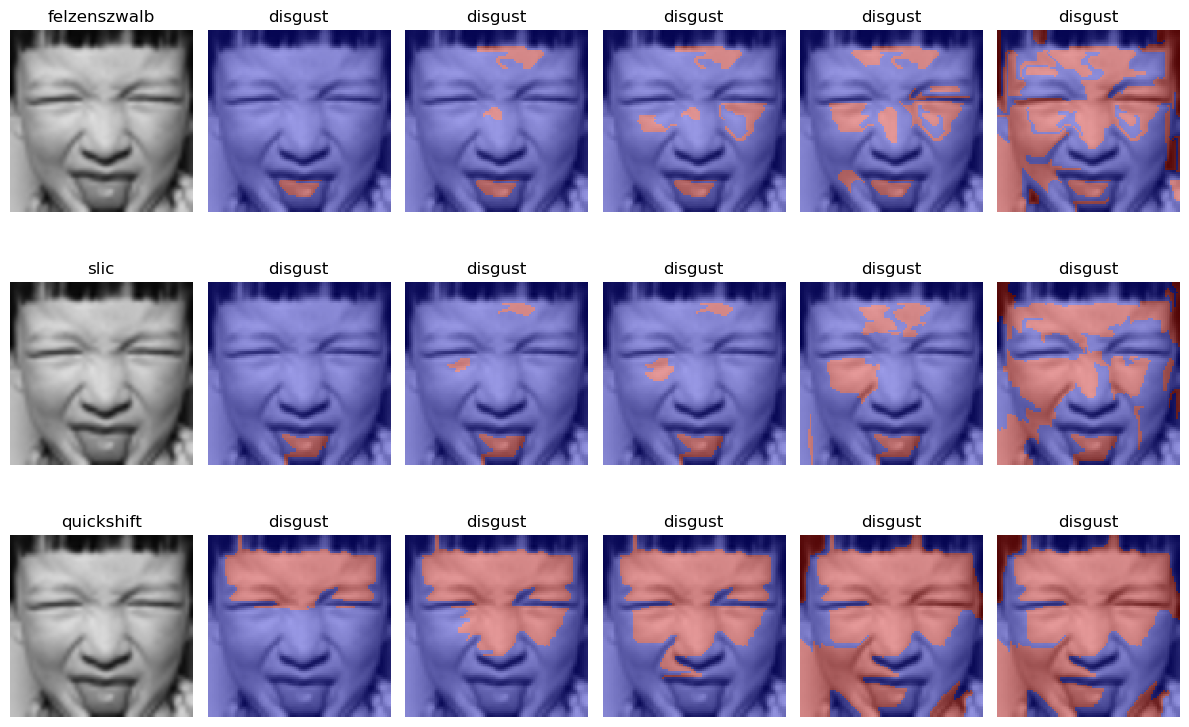

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:17<00:00, 128.70it/s]


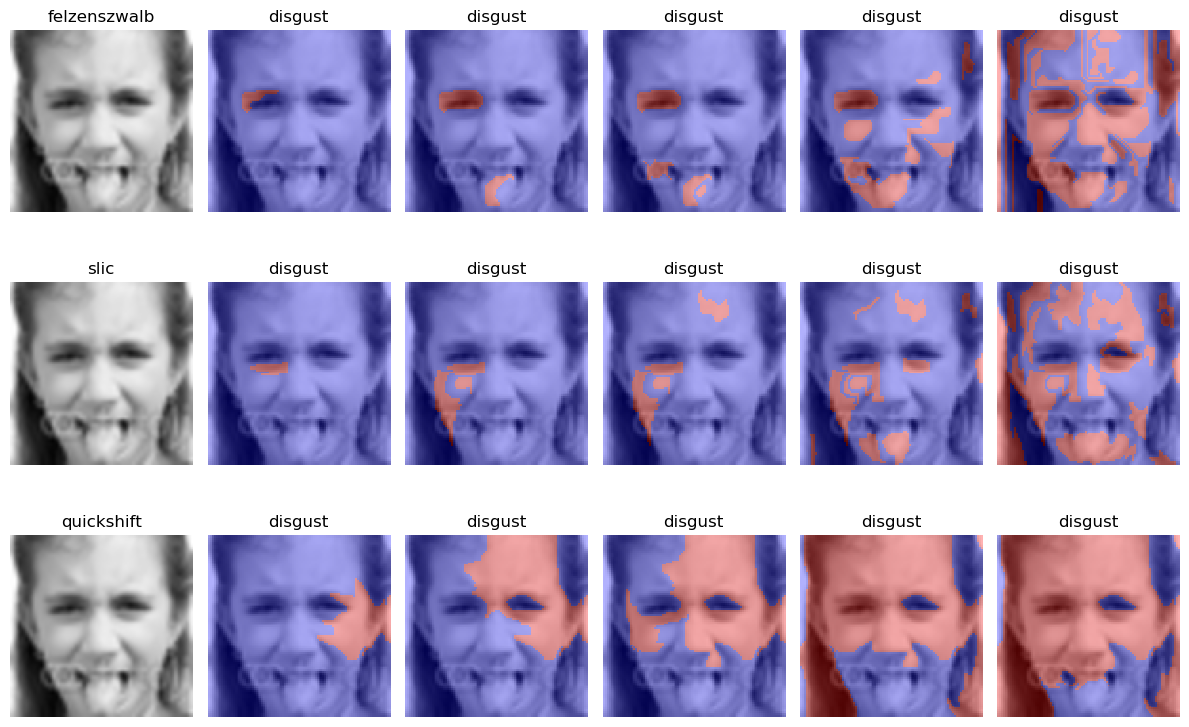

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 123.26it/s]


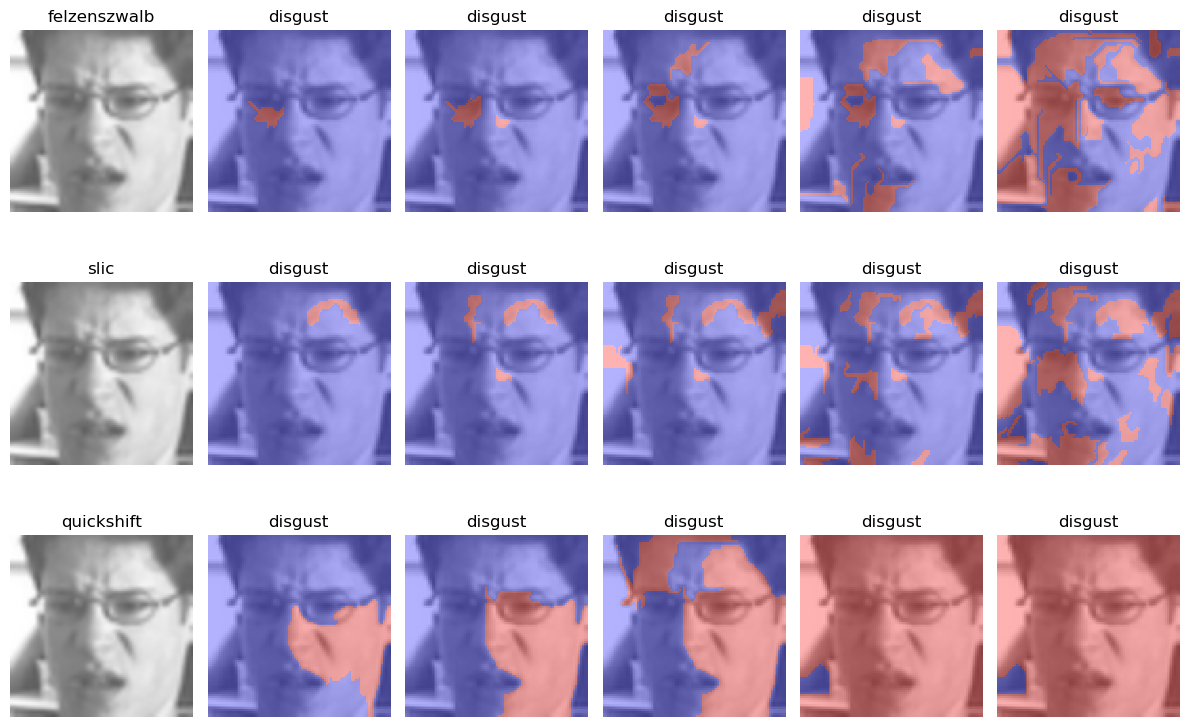

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:20<00:00, 123.51it/s]


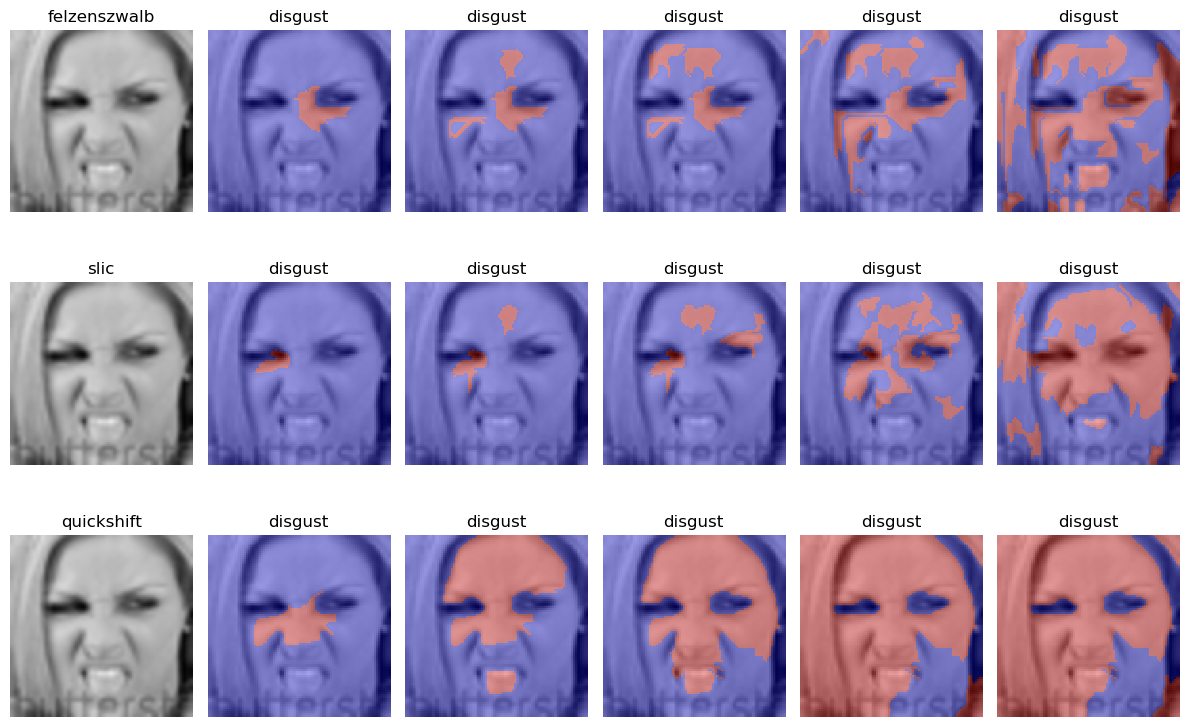

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.26it/s]


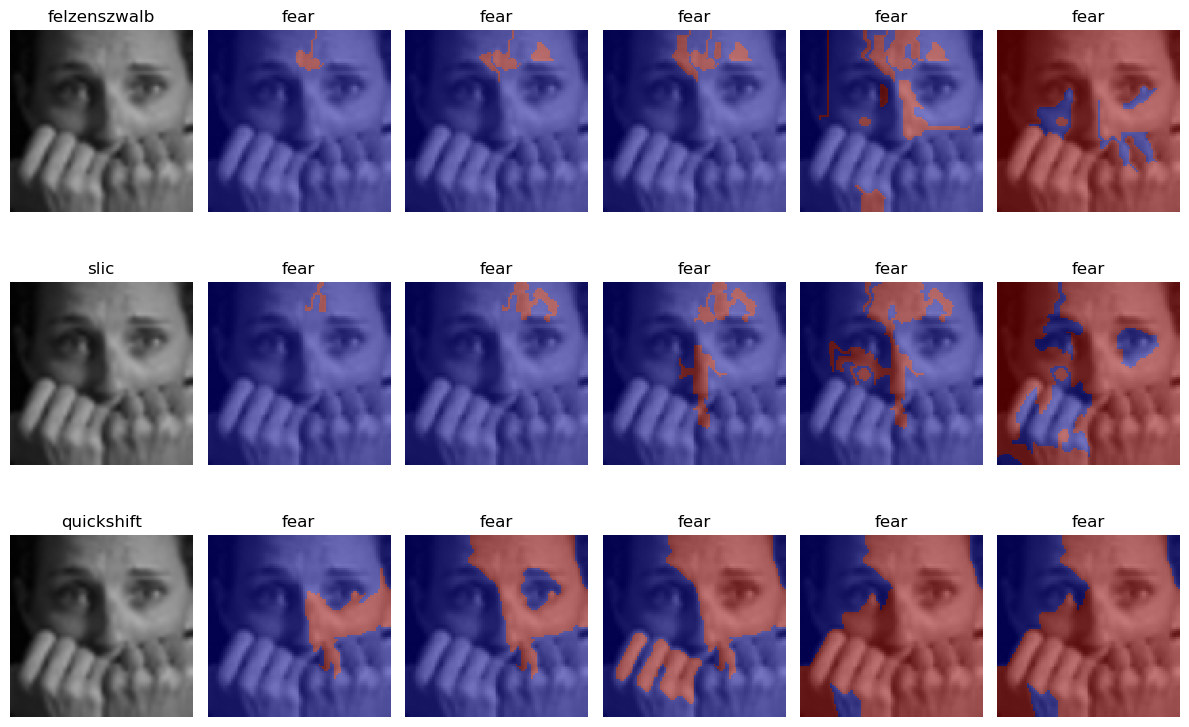

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:18<00:00, 128.06it/s]


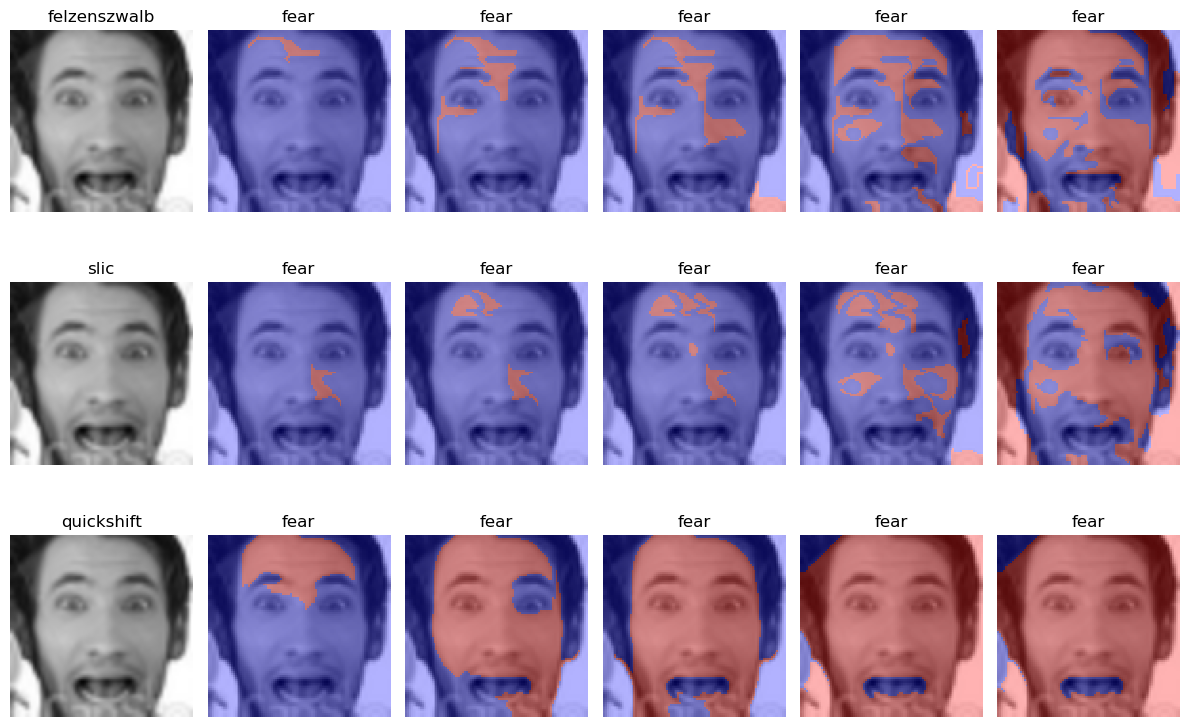

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 134.44it/s]


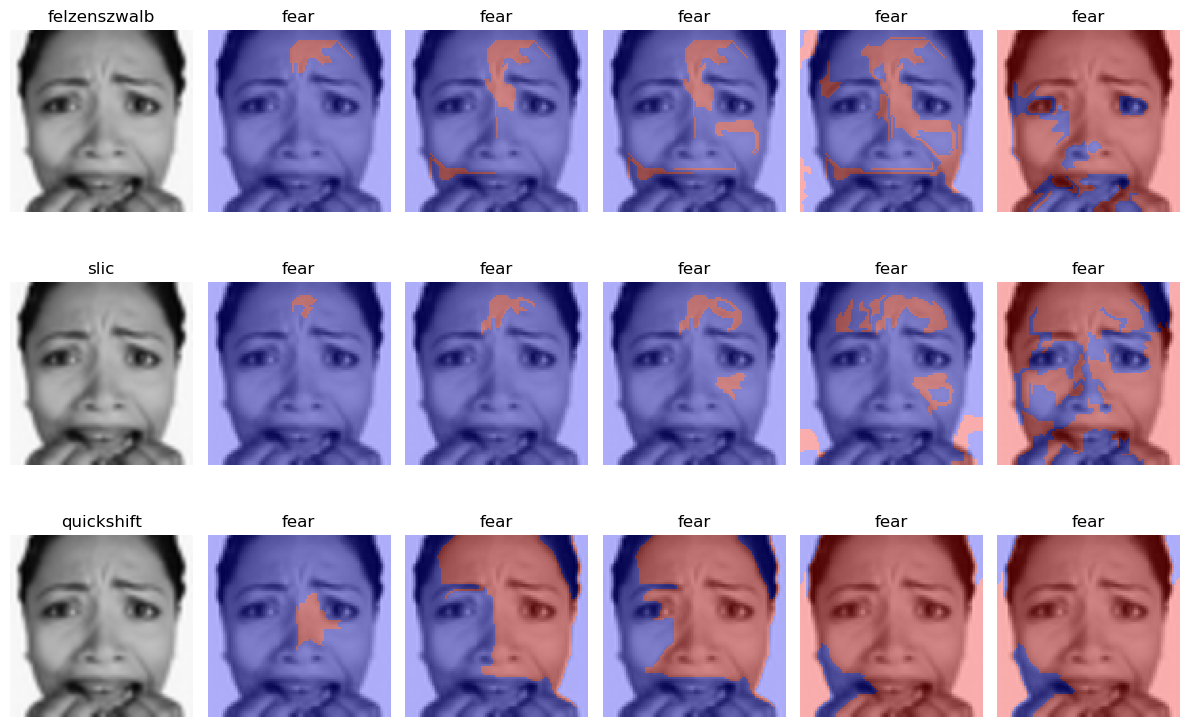

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.35it/s]


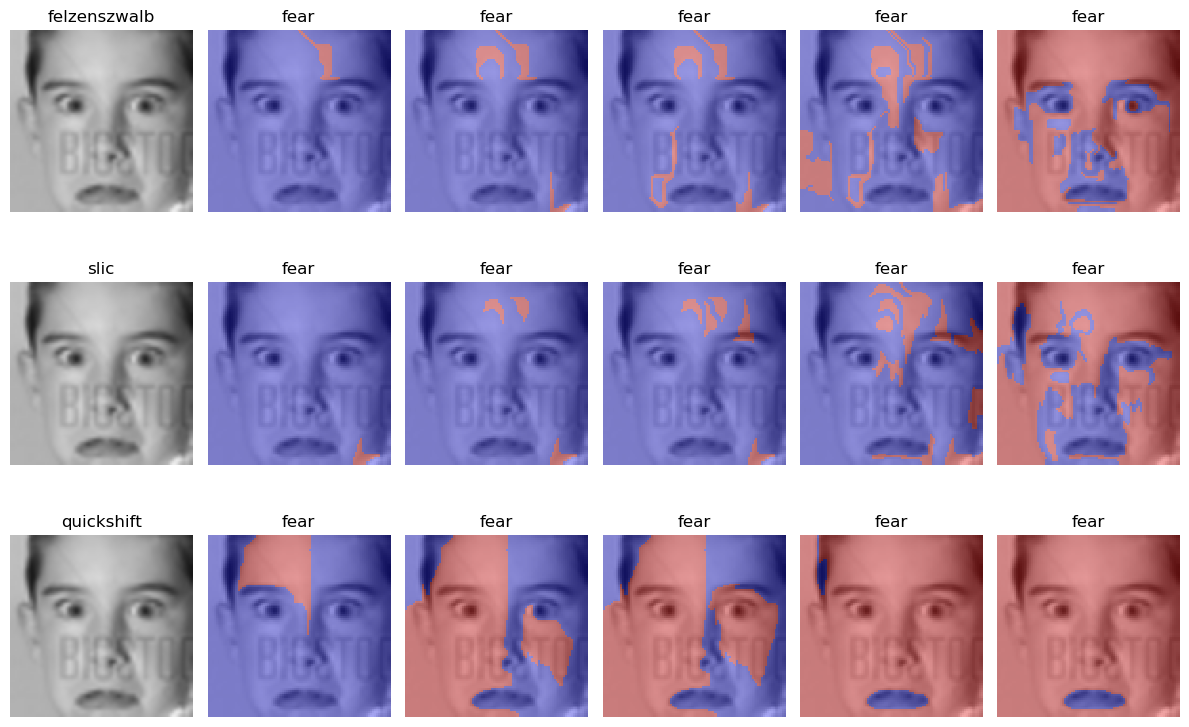

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 133.65it/s]


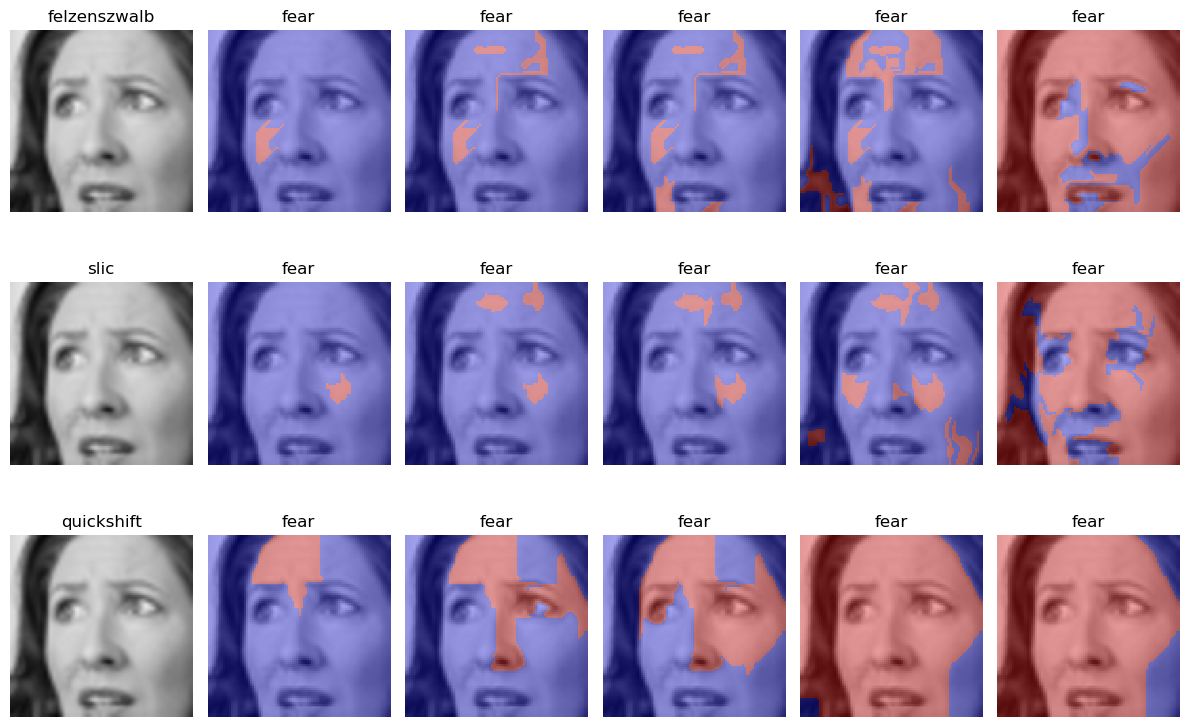

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.53it/s]


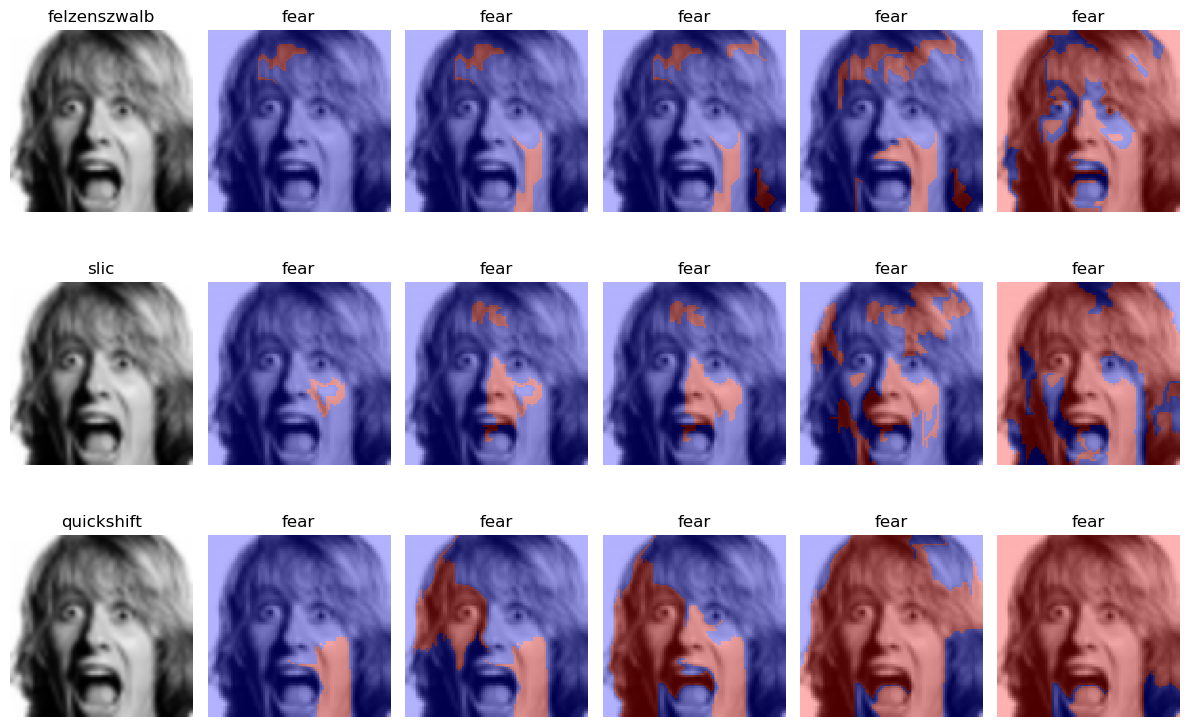

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.74it/s]


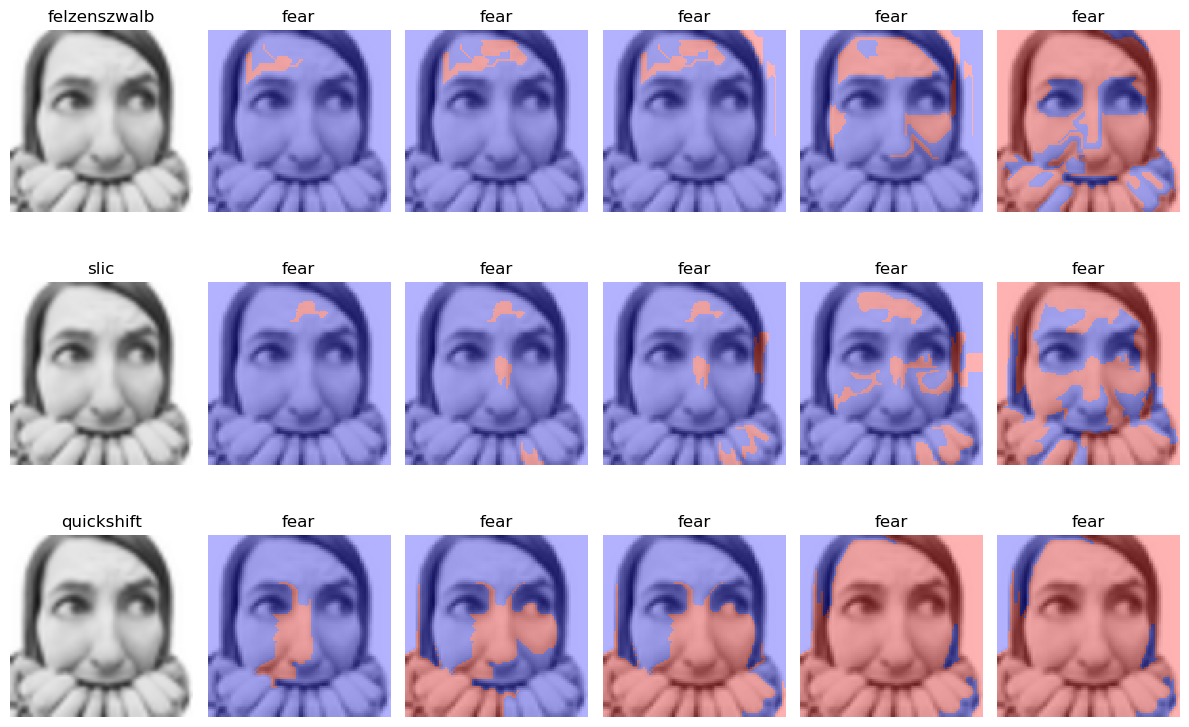

In [19]:
explain(IMAGE_NUMBERS0)
explain(IMAGE_NUMBERS1)
explain(IMAGE_NUMBERS2)

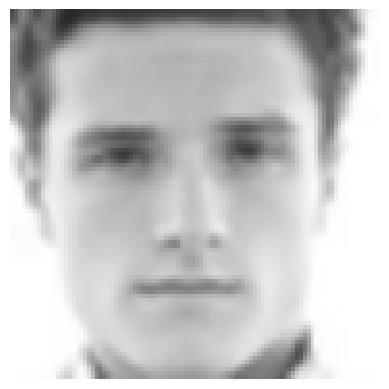

In [20]:
import matplotlib.pyplot as plt

# Index of the image you want to visualize
IMAGE_NUMBER = 2000

# Retrieve the image from X_test
image = X_test[IMAGE_NUMBER]

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()
